<a href="https://colab.research.google.com/github/SheriffOladejo/DeepLearning/blob/main/Paddy_Disease_Classification_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install fastkaggle fastai

In [4]:
import fastkaggle


comp = 'paddy-disease-classification'
path = fastkaggle.setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')
from fastai.vision.all import *
set_seed(42)

100%|██████████| 1.02G/1.02G [00:04<00:00, 237MB/s]


In [5]:
trn_path = Path('sml')

In [6]:
resize_images(path/'train_images', dest=trn_path, max_size=256, recurse=True)

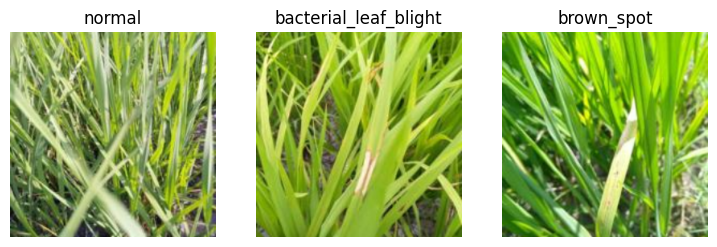

In [7]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(256, 192))
dls.show_batch(max_n=3)

In [8]:
def train(arch, item, batch, epochs=5):
  dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
  learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
  learn.fine_tune(epochs, 0.01)
  return learn

In [9]:
learn = train('resnet26d', item=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,1.919382,1.424925,0.460356,00:35


epoch,train_loss,valid_loss,error_rate,time
0,1.301991,0.931978,0.301297,00:41
1,1.011954,0.732039,0.235944,00:37
2,0.712897,0.459154,0.148967,00:28
3,0.537605,0.365453,0.111485,00:27
4,0.424764,0.365484,0.108602,00:28


In [10]:
arch = 'convnext_small_in22k'

In [11]:
learn = train(arch, item=Resize(192, method='squish'), batch=aug_transforms(size=128, min_scale=0.75))

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.295238,0.866274,0.275829,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.643343,0.509250,0.171072,00:44
1,0.488698,0.369837,0.121096,00:52
2,0.336257,0.230428,0.076406,00:53
3,0.181429,0.164197,0.046612,00:49
4,0.131071,0.153227,0.049015,00:57


In [12]:
learn = train(arch, item=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.352434,0.940974,0.287842,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.724543,0.390207,0.127823,00:40
1,0.555803,0.368042,0.120135,01:02
2,0.354211,0.252143,0.082172,00:43
3,0.236908,0.159630,0.046612,00:41
4,0.173167,0.151197,0.043729,00:39


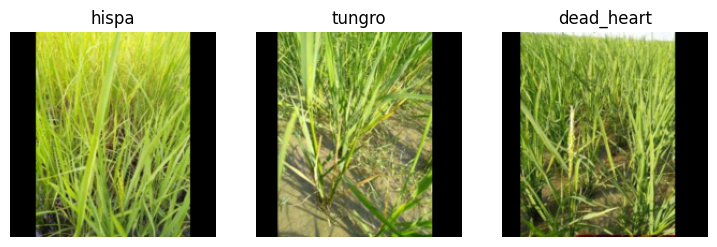

In [13]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [ ]:
learn = train(arch, item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch=aug_transforms(size=(171, 128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.262650,0.735441,0.242672,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.698152,0.443618,0.138876,00:43


In [ ]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [ ]:
from fastai.vision.all import *
from fastai.metrics import error_rate
error_rate(preds, targs)

In [ ]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [ ]:
tta_preds,_ = learn.tta(dl=valid)

In [ ]:
error_rate(tta_preds, targs)

In [ ]:
trn_path = path/"train_images"

In [ ]:
learn = train(arch, epochs=12, item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch=aug_transforms(size=(256, 192), min_scale=0.75))

In [ ]:
tst_files = get_image_files(path/"test_images").sorted()
tst_dl = learn.dls.test_dl(tst_files)

In [ ]:
preds, _ = learn.tta(dl=tst_dl)

In [ ]:
idxs = preds.argmax(dim=1)

In [ ]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('subm.csv', index=False)
